# Main

In [1]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sn

import keras_metrics
import tensorflow as tf

from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


## Parameters

In [2]:
classes = pd.read_csv('ingredients_labeled.csv')
CLASSES = classes['ingredient'].dropna().values.tolist()

In [3]:
MODEL = 'resnet'

INPUT_SHAPE = (100, 100, 3)
NUM_CLASSES =  len(CLASSES)
LEARNING_RATE = 0.001
PATIENCE = 3
VERBOSE = 1
LEARNING_RATE_REDUCTION_FACTOR = 0.5
MIN_LEARNING_RATE = 0.00001

EPOCHS = 25
BATCH_SIZE = 50

MODEL_NAME = 'multilabel_base_2'
OUTPUT_DIR = 'output'
SEED = 42

MODEL_OUT_DIR = os.path.join(OUTPUT_DIR, MODEL_NAME)
                            
if not os.path.exists(MODEL_OUT_DIR):
    os.makedirs(MODEL_OUT_DIR)

## Load Data

In [4]:
train_labeled = pd.read_csv('data/train_labeled.csv').dropna()
test_labeled = pd.read_csv('data/test_labeled.csv').dropna()
val_labeled = pd.read_csv('data/val_labeled.csv').dropna()

In [5]:
train_labeled['ingredients_cleaned'] = train_labeled['ingredients_cleaned'].apply(lambda x:x.split(","))
test_labeled['ingredients_cleaned'] = test_labeled['ingredients_cleaned'].apply(lambda x:x.split(","))
val_labeled['ingredients_cleaned'] = val_labeled['ingredients_cleaned'].apply(lambda x:x.split(","))

## Create the model

In [6]:
def image_process(x):
    import tensorflow as tf
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez

def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(image_process)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='sigmoid', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

def resnet(input_shape, num_classes):
    resnet = ResNet50(weights='imagenet',
                       input_shape=input_shape,
                   include_top=False)
    image = resnet.get_layer(index=0).output
    output = resnet.get_layer(index=-1).output
    output = Flatten()(output)
    output = Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    resnet = Model(inputs = image, outputs = output)
    return resnet

def inception(input_shape, num_classes):
    inception = InceptionV3(weights='imagenet',
                           input_shape=input_shape,
                           include_top=False)
    
    image = inception.get_layer(index=0).output
    output = inception.get_layer(index=-1).output
    output = Flatten()(output)
    output = Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    inception = Model(inputs = image, outputs = output)
    return inception

if MODEL == 'inceptionv3':
    model = inception(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
elif MODEL == 'resnet':
    model = resnet(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
else:
    model = network(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)


C:\Users\melvi\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


## Creating the Data Generators

In [7]:
datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,  # randomly flip images
)


train_generator = datagen.flow_from_dataframe(
    dataframe=train_labeled,
    directory="./Recipes5k/images/",
    x_col="url",
    y_col="ingredients_cleaned",
    batch_size=32,
    seed=SEED,
    shuffle=True,
    class_mode="categorical",
    classes=CLASSES,
    target_size=(100,100)
)

Found 3959 validated image filenames belonging to 227 classes.


In [8]:
test_datagen = ImageDataGenerator()


test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labeled,
    directory="./Recipes5k/images/",
    x_col="url",
    y_col="ingredients_cleaned",
    batch_size=1,
    seed=SEED,
    shuffle=False,
    class_mode="categorical",
    classes=CLASSES,
    target_size=(100,100)
)

Found 782 validated image filenames belonging to 227 classes.


In [9]:
val_datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,  # randomly flip images
)

In [10]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labeled,
    directory="./Recipes5k/images/",
    x_col="url",
    y_col="ingredients_cleaned",
    batch_size=32,
    seed=SEED,
    shuffle=False,
    class_mode="categorical",
    classes=CLASSES,
    target_size=(100,100)
)

Found 634 validated image filenames belonging to 227 classes.


# Creating the model and starting training

In [11]:
opt = Adam(lr = LEARNING_RATE)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(
                    monitor='val_loss', 
                    patience=PATIENCE, verbose=VERBOSE, 
                    factor=LEARNING_RATE_REDUCTION_FACTOR, 
                    min_lr=MIN_LEARNING_RATE
)
save_model = ModelCheckpoint(filepath=MODEL_OUT_DIR + "/model.h5", monitor='val_accuracy', verbose=VERBOSE, 
                             save_best_only=True, save_weights_only=False, mode='max', period=1)

history = model.fit_generator(generator=train_generator,
                                  epochs=EPOCHS,
                                  steps_per_epoch=(train_generator.n // BATCH_SIZE) + 1, 
                                  verbose=VERBOSE,
                                  validation_data=val_generator,
                                  validation_steps=(val_generator.n // BATCH_SIZE) + 1,
                                  callbacks=[learning_rate_reduction, save_model]
                             )
# weights = model.load_weights(MODEL_OUT_DIR + "/model.h5")
# weights

Epoch 1/25
80/80 [==============================] - 222s 3s/step - loss: 0.1462 - accuracy: 0.9559 - val_loss: 2.0423 - val_accuracy: 0.9575

Epoch 00001: val_accuracy improved from -inf to 0.95749, saving model to output\multilabel_base_2/model.h5
Epoch 2/25
80/80 [==============================] - 210s 3s/step - loss: 0.1160 - accuracy: 0.9633 - val_loss: 0.7974 - val_accuracy: 0.9601

Epoch 00002: val_accuracy improved from 0.95749 to 0.96008, saving model to output\multilabel_base_2/model.h5
Epoch 3/25
80/80 [==============================] - 210s 3s/step - loss: 0.1157 - accuracy: 0.9632 - val_loss: 0.2475 - val_accuracy: 0.9622

Epoch 00003: val_accuracy improved from 0.96008 to 0.96225, saving model to output\multilabel_base_2/model.h5
Epoch 4/25
80/80 [==============================] - 211s 3s/step - loss: 0.1137 - accuracy: 0.9630 - val_loss: 2.6169 - val_accuracy: 0.9619

Epoch 00004: val_accuracy did not improve from 0.96225
Epoch 5/25
80/80 [==============================] 

# Evaluate the model and predict on the test data 

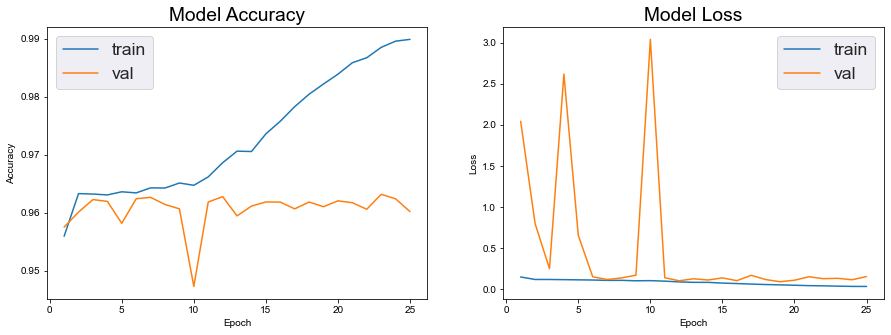

In [12]:
def plot_model_history(model_history, out_path=""):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    sn.set(font_scale=1.6)#for label size
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    # save the graph in a file called "acc_loss.png" to be available for later; the model_name is provided when creating and training a model
    if out_path:
        plt.savefig(out_path + "/acc_loss.png")
    plt.show()

plot_model_history(history, out_path=MODEL_OUT_DIR)

In [13]:
# model.load_weights(MODEL_OUT_DIR + "/model.h5")

val_generator.reset()
test_generator.reset()
loss_v, accuracy_v = model.evaluate_generator(val_generator, steps=(val_generator.n // BATCH_SIZE) + 1, verbose=VERBOSE)
loss, accuracy = model.evaluate_generator(test_generator, steps=test_generator.n, verbose=VERBOSE)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))

782/782 [==============================] - 31s 39ms/step
Validation: accuracy = 0.961327  ;  loss_v = 0.161362
Test: accuracy = 0.962324  ;  loss_v = 0.024593


In [14]:
model.load_weights(MODEL_OUT_DIR + "/model.h5")

In [15]:
def decode_predictions(predictions, min_val = 0.5):
    """ Decodes the predictions from the output sigmoid function"""
    positive_predictions = []
    for row in predictions:
        positive_pred = np.argwhere(row > min_val)
        if len(positive_pred):
            positive_pred = np.concatenate(positive_pred)
        positive_predictions.append(positive_pred.tolist())
    return positive_predictions


def get_non_vegetarian_ingredients():
    ingredients_labeled = pd.read_csv('ingredients_labeled.csv', index_col='ingredient')
    
    ingredients_labeled = ingredients_labeled.loc[~ingredients_labeled.index.duplicated(keep='first')]
    ingredients_labeled['non-vegetarian'] = ~ingredients_labeled['vegetarian']
    res = {value: ingredients_labeled.loc[key]['non-vegetarian'] 
                                  for key, value in test_generator.class_indices.items()}
    return res
    

def predict_vegetarian(positive_predictions):
    non_vegetarian_ingredients = get_non_vegetarian_ingredients()
    binary_predictions = []
    for prediction in positive_predictions:
        binary = False
        for pred in prediction:
            if non_vegetarian_ingredients[pred]:
                binary = True
        binary_predictions.append(binary)
    return binary_predictions

In [16]:
y_pred = model.predict_generator(test_generator, steps=test_generator.n, verbose=VERBOSE)
positive_pred = decode_predictions(y_pred)
binary_pred = predict_vegetarian(positive_pred)

782/782 [==============================] - 32s 41ms/step


In [17]:
test_labeled['bool_label'] = test_labeled['label'] != 'Vegetarian'
binary_true = test_labeled['bool_label']

In [18]:
confusion_matrix(binary_true, binary_pred)

array([[435,  27],
       [253,  67]], dtype=int64)

In [19]:
accuracy_score(binary_true, binary_pred)

0.6419437340153452

In [20]:
test_labeled['label'].value_counts()

Vegetarian        462
Vegetarian-Not    320
Name: label, dtype: int64

In [21]:
463/792

0.5845959595959596

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(40, 40))
    sn.set(font_scale=6)#for label size
    ax = sn.heatmap(df_cm, cmap="Blues", annot=True, cbar=False, fmt='d', annot_kws={"size": 80})
    if out_path:
        plt.savefig(out_path + "/new_confusion_matrix.png")  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    return ax

In [30]:
labels = ['Vegetarian', 'Not-Vegetarian']

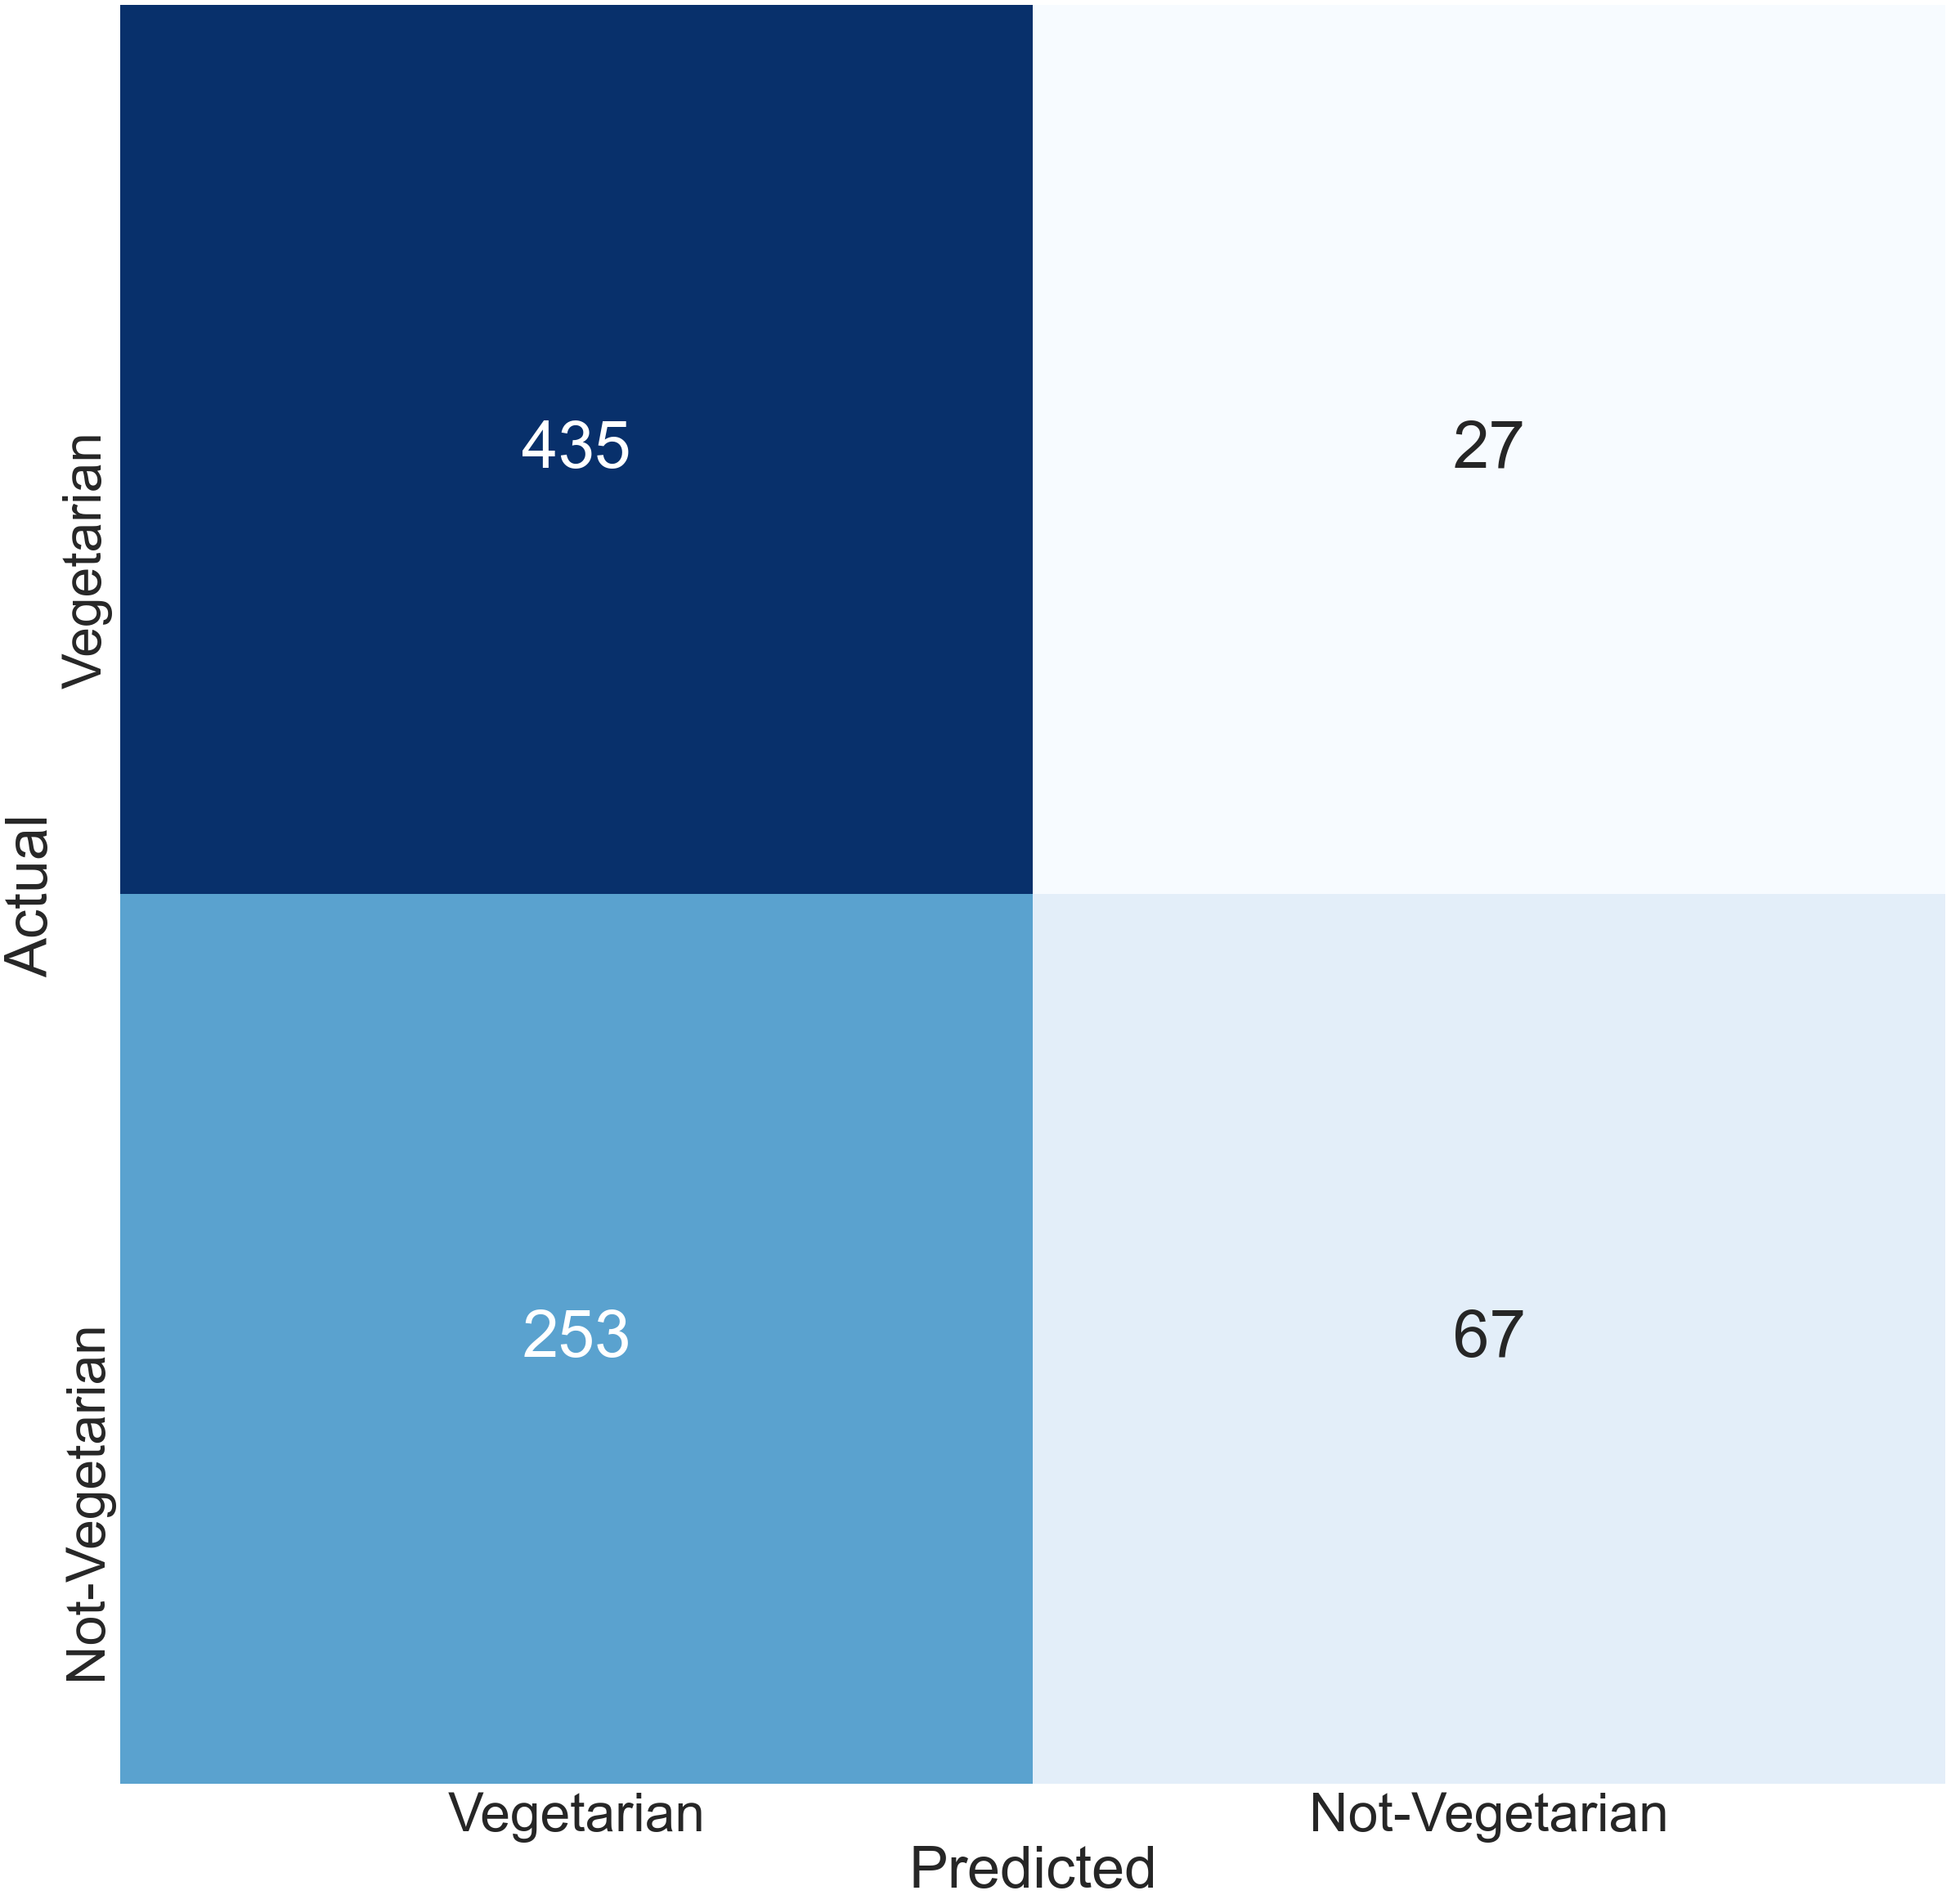

In [31]:
plot_confusion_matrix(binary_true, binary_pred, labels, out_path=MODEL_OUT_DIR)

In [25]:
class_report = classification_report(binary_true, binary_pred, target_names=labels)

with open(MODEL_OUT_DIR + "/new_classification_report.txt", "w") as text_file:
    text_file.write("%s" % class_report)
print(class_report)

                precision    recall  f1-score   support

    Vegetarian       0.63      0.94      0.76       462
Not-Vegetarian       0.71      0.21      0.32       320

      accuracy                           0.64       782
     macro avg       0.67      0.58      0.54       782
  weighted avg       0.67      0.64      0.58       782

